# Exploration
A brief look into the data and how it is graphed as a whole. Plots cleaned data to explore any immediately noticeable trends. Bootstrapped the data with sampling from the existing data. Sampling data is averaged with the original data with sampling data being weighted at 1/3 of the average.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import numpy as np
import pandas as pd
import os

import stats

## Read Files Written in 02-DataCleaning

In [2]:
polls = pd.read_csv('polls.csv')
candidates = pd.read_csv('candidates.csv', index_col='name')

Convert date from string to datetime.

In [3]:
polls.date = pd.Series(pd.DatetimeIndex(polls.date))
polls.index = polls.date
del polls['date']

candidates.date = pd.to_datetime(candidates.date)

## Graph
Displays all data used at large.

In [4]:
def GraphAllPolls():
    """Graphs out all polling data"""
    plt.figure(figsize=(20,10))

    for p in polls:
        plt.plot(polls[p])

    plt.axvline(candidates['date']['Rubio'], color='#c9c95b')
    plt.axvline(candidates['date']['Carson'], color='#c9c95b')
    plt.axvline(candidates['date']['Bush'], color='#72bcd4')
    # Christie and Fiorina dropped out on the same day. Offset Christie's line by several hours so both lines display
    plt.axvline(candidates['date']['Christie'] + datetime.timedelta(hours=8), color='b') 
    plt.axvline(candidates['date']['Fiorina'], color='#66b266')
    plt.axvline(candidates['date']['Gilmore'], color='#e54444')
    plt.axvline(candidates['date']['Huckabee'], color='purple')
    # Paul and Santorum dropped out on the same day. Offset Paul's line by several hours so both lines display
    plt.axvline(candidates['date']['Paul'] + datetime.timedelta(hours=8), color='#c9c95b')
    plt.axvline(candidates['date']['Santorum'], color='#72bcd4')

    plt.title("GOP Candidate Polling", size=20)
    plt.xlabel("Date of Poll", size=16)
    plt.ylabel("Polling Percentage", size=16)

    # x and y limits are a little greater than needed to display the legend without blocking out data
    plt.xlim('2016-01-03', datetime.date.today() + datetime.timedelta(days=7))
    plt.ylim(0, 60)
    plt.legend(fontsize=12)

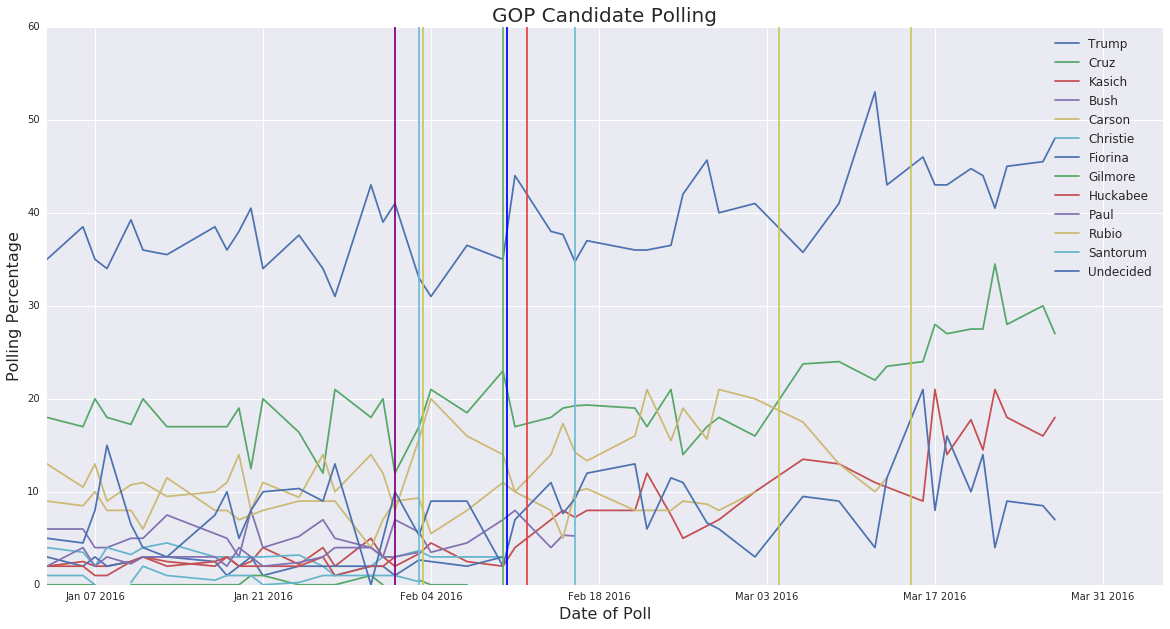

In [5]:
GraphAllPolls()

## Sampling the Data
Bootstrap data by sampling 10 and averaging it out. It is then averaged with the original data. This is a weighted average with the original data having 2/3 the weight and the bootstrapped data having 1/3 the weight.

In [6]:
def bootstrap(data, l=100):
    """Samples data l times and averages the sampled data with the original data. The original data is weighted twice
    as much as the sampled data.
    
    Parameters
    ----------
    data : DataFrame
        DataFrame holding all polling data.
    l : int
        Amount of times to sample data.
    """
    
    data = data.fillna(0)
    
    means = []
    for i in range(l):
        means.append(data.sample(n=len(polls.index), replace=False))
        means[i].index = data.index
    
    avg = sum(means)
    return (avg + data * l * 2)/(l * 3)

Get a glimpse of the difference between the original polling data and the bootstrapped data.

In [7]:
bootPolls = bootstrap(polls)
(polls - bootPolls).tail()

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
date,,,,,,,,,,,,,
2016-03-21,1.885000,2.356389,2.340556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.745833
2016-03-22,0.832833,5.259944,5.036778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.326333
2016-03-23,2.081056,2.633111,3.517667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175778
2016-03-26,1.838278,3.182833,2.831833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.063667
2016-03-27,2.915111,2.175722,3.523556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.499333


In [8]:
polls = bootPolls

If a candidate drops out and they still appear in the polls, add their polling percentage to 'Undecided' and make their value 'NaN'.

In [9]:
for c in candidates.index:
    date = str(candidates.loc[c]['date'])
    if date != 'NaT':
        polls.loc[(polls[c].notnull()) & (polls.index > date), 'Undecided'] += \
            polls[(polls[c].notnull()) & (polls.index > date)][c]
        polls.loc[(polls[c].notnull()) & (polls.index > date), c] = float('NaN')

polls.tail()

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
date,,,,,,,,,,,,,
2016-03-21,42.115000,25.143611,12.159444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.581944
2016-03-22,39.667167,29.240056,15.963222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.129556
2016-03-23,42.918944,25.366889,14.482333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.231833
2016-03-26,43.661722,26.817167,13.168167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.352944
2016-03-27,45.084889,24.824278,14.476444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.614389


Confirm polls still sum up to 100.

In [10]:
stats.Equals100(polls)
for p in range(len(polls.index)):
    assert sum(polls.iloc[p].dropna()) == 100

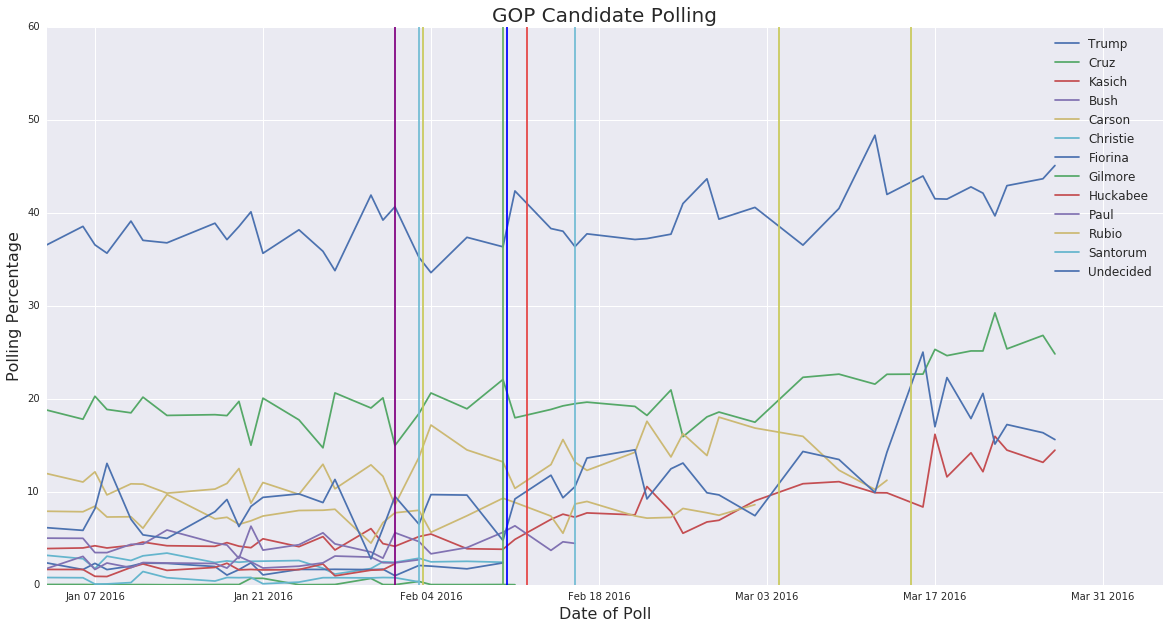

In [11]:
GraphAllPolls()

## Write Data to Files
Write bootstrapped polling data to file.

In [12]:
polls.to_csv('bootPolls.csv')